**1 도입**<br>
**2 데이터 로드 및 체크**<br>
*   2.1 데이터 로드
*   2.2 이상치 탐색
*   2.3 train과 test셋 결합
*   2.4 null과 결측값 체크

**3 특성 분석**
*   3.1 수치형 변수
*   3.2 범주형 변수

**4 결측값 채우기**
*   4.1 Age

**5 특성 공학**
*   5.1 Name/Title
*   5.2 Family Size
*   5.3 Cabin
*   5.4 Ticket

**6 모델링**
*   6.1 Simple modeling
    <br>1) 교차 검증
    <br>2) 최적 모델을 위한 하이퍼 파라미터 튜닝
    <br>3) 학습 곡선 그리기
    <br>4) Feature importance of the tree based classifiers 
*   6.2 Ensemble modeling
    <br>1) Combining models
*   6.3 Prediction
    <br>1) Predict and Submit results















# 1. 도입
Titanic competition은 feature engineering 과 ensemble modeling을 소개하기에 좋아 이것을 Kaggle에서의 내 첫 번째 커널로 선택했다. 첫째로, 나는 몇몇 feature를 분석 후 feature engineering에 중점을 둘 것이다. 마지막 파트에서는 voting 절차를 이용한 Titanic의 생존율을 modeling과 predicting 할 것이다.

이 스크립트는 다음과 같이 세 개의 메인 파트로 구분된다:
*   Feature analysis
*   Feature engineering
*   Modeling

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
!ls

gdrive	sample_data


In [0]:
# from google.colab import files
# uploaded = files.upload()

#2. 데이터 로드 및 확인
2.1 데이터 로드

In [4]:
# Load data
#### Load train and Test set
import os
print(os.getcwd())
!ls

/content
gdrive	sample_data


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train = pd.read_csv('gdrive/My Drive/kaggleData/train.csv')
test = pd.read_csv('gdrive/My Drive/kaggleData/train.csv')
IDtest = test['PassengerId']

In [7]:
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


2.2 Outlier detection

In [0]:
# Outlier detection

def detect_outliers(df, n, features):
  """
  feature의 데이터프레임 df를 가져와서 Tukey 방법에 따라 
  n개 이상의 이상치를 포함하는 관측치에 해당하는 인덱스 목록을 반환한다."""
  
  outlier_indices = []

  # iterate over features(columns)
  for col in features:
    # 1분위(25%)
    Q1 = np.percentile(df[col], 25)
    # 3분위(75%)
    Q3 = np.percentile(df[col],75)
    # 사분위수 범위(IQR: Interquartile range)
    IQR = Q3 - Q1

    # 이상치 스텝
    outlier_step = 1.5 * IQR

    # feature 열에 대한 이상치의 인덱스 목록 결정
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    # 열에 대해 찾은 이상치 인덱스를 이상치 인덱스 목록에 추가
    outlier_indices.extend(outlier_list_col)

  # 이상치가 2개 이상인 관측값 선택
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers

# Age, SibSp, Parch, Fare 의 이상치 탐색
Outliers_to_drop = detect_outliers(train, 2, ['Age','SibSp','Parch','Fare'])

이상치는 예측(특히, 회귀 문제)에 큰 영향을 미칠 수 있기 때문에 이를 관리하기로 했다.

여기서는 Tukey 방법(Tukey JW., 1977)을 사용하여 분포값(IQR)의 1사분위와 3사분위 사이에 포함된 사분위수 범위를 정의하는 이상치를 탐색했다. 이상치는 (IQR +- 이상치 스텝) 외부에 feature 값이 있는 행이다.

수치값 feature(Age, SibSp, Parch, Fare)들에서 이상치를 탐색하기로 결정했다. 그 후 이상치를 적어도 두 개의 이상 수치값이 있는 행으로 간주했다.

In [9]:
train.loc[Outliers_to_drop]   # 이상치 열 나타내기

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상치를 탐색한다. 28, 89, 342 승객은 높은 운임료를 보인다. 나머지 7명은 SibSp에서 높은 값을 보인다.

In [0]:
# 이상치 제거
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

**2.3 train과 test set 결합하기**

In [0]:
# 범주 변환 중에 동일한 수의 feature들을 얻기 위해 train과 test 데이터셋을 결합
train_len = len(train)
dataset = pd.concat(objs=[train, test],axis=0).reset_index(drop=True)

범주 변환 중에 동일한 수의 feature들을 얻기 위해 train과 test 데이터셋을 결합한다.(feature engineering 참조)

**2.4 null과 결측값 확인**

In [12]:
# 비어있는 값과 NaN값을 NaN으로 채우기
dataset = dataset.fillna(np.nan)

# Null 값 체크
dataset.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             347
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1367
Embarked          4
dtype: int64

Age와 Cabin feature는 결측값에서 중요한 부분을 차지한다.

**Survived 결측값은 결합한 testing dataset에 해당한다.(Survived 열은 test set에 존재하지 않으며, train과 test set을 합칠 때 NaN 값으로 대체되었다.)**

In [13]:
# Infos   # 컬럼별 type 확인 및 결측치 확인
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [16]:
### 데이터 요약하기
# 요약 및 통계
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature 분석
3.1 수치형 변수

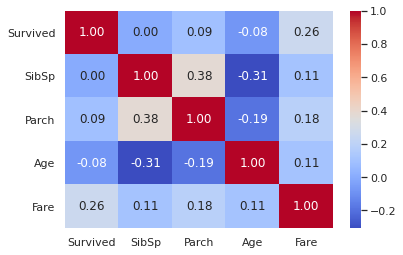

In [17]:
# 수치형 변수와 Survived의 Correlation matrix (SibSp, Parch, Age, Fare values)
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,fmt='.2f',cmap='coolwarm')

Fare feature만 생존율과 유의한 상관관계가 있는 것으로 보인다.

이는 다른 feature들이 유용하지 않다는 의미는 아니다. 이러한 feature들의 부차 집단은 생존과 연관될 수 있다. 이를 확인하기 위해서는 해당 feature들을 자세히 살펴봐야 한다.

**SipSp**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


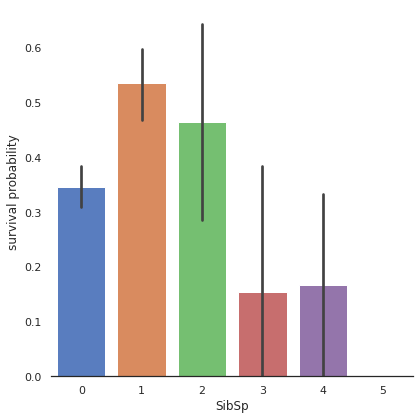

In [18]:
# SibSp feature vs Survived 탐색
g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

형제자매/배우자가 많은 승객은 생존 확률이 낮다.

홀로인 승객(0 SibSp) 또는 다른 두 사람(SibSp 1 또는 2)과 함께 생존할 가능성이 더 높아보인다.

이 관찰은 매우 흥미롭기에 우리는 이러한 범주를 설명하는 새로운 feature를 고려할 수 있다.(feature engineering 참조)

**Parch**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


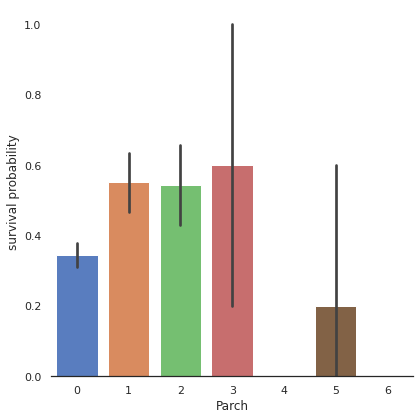

In [19]:
# Parch feature vs Survived 탐색
g = sns.factorplot(x='Parch',y='Survived',data=train, kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

소가족은 싱글(Parch 0)과 중간규모(Parch 3,4) 및 대가족(Parch 5,6)보다 생존 확률이 좀 더 높다.

부모/자녀가 3명인 승객의 생존에 중요한 표준 편차가 있음에 주의해야 한다.

**Age**

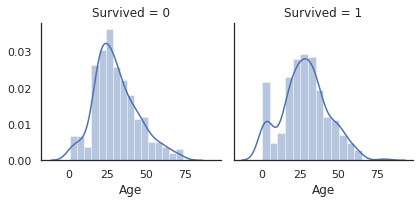

In [20]:
# Age vs Survived 탐색
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot,'Age')

연령 분포는 tailed 분포로 보이며 가우스 분포인 것 같다.

우리는 연령 분포가 생존한 하위집단과 사망한 하위집단에서 동일하지 않음을 알 수 있다. 실제로, 생존한 집단에서는 젊은 나이대에서 최고점을 보인다. 또한, 60~80세 승객들은 적게 생존한 것으로 나타난다.

따라서 'Age'가 'Survived'와 상관되지 않더라도 생존할 확률이 어느 정도인 승객의 연령 범주가 있음을 알 수 있다.

아주 어린 승객들은 생존 확률이 더 높은 것으로 보인다.

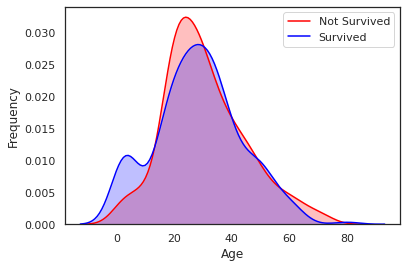

In [21]:
# Age 분포 탐구
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red',shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue", shade= True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

두 밀도를 중첩할 때, 우리는 0~5세의 아기와 아주 어린 아이들에 대한 피크를 분명하게 볼 수 있다.

**Fare**

In [22]:
dataset['Fare'].isnull().sum()

0

In [0]:
#Fare 결측값을 중앙값으로 채우기
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

결측값이 1개만 있으므로 중앙값으로 채워도 예측에 중요한 영향을 미치지 않을 것이다.

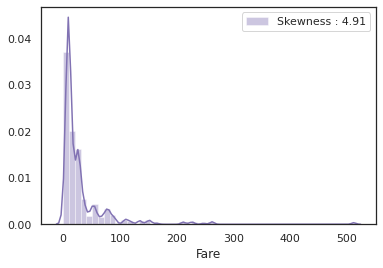

In [24]:
# Fare 분포 탐색
g = sns.distplot(dataset['Fare'],color='m',label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

Fare 분포는 매우 편향되어 나타난다.이는 스케일링 되어도 모델에서 매우 높은 값을 과도하게 만들 수 있다.

이 경우, 이러한 편향성을 줄이기 위해 로그 함수로 이를 변환시키는 것이 좋다.

In [0]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i:np.log(i) if i>0 else 0)

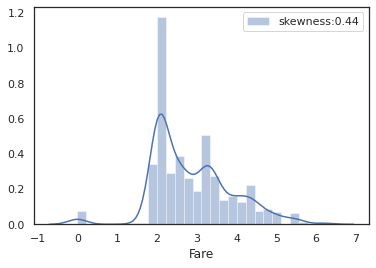

In [26]:
g = sns.distplot(dataset['Fare'], color = 'b', label='skewness:%.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

로그 변환 후 편향성이 명확하게 감소했다.

#####3.2 Categorical values

Sex

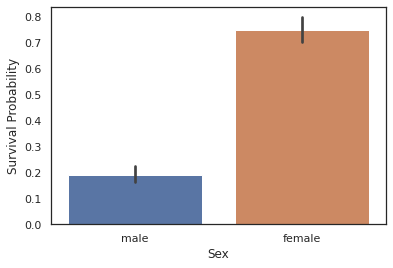

In [27]:
g = sns.barplot(x='Sex',y='Survived',data=train)
g = g.set_ylabel('Survival Probability')

In [28]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성이 여성보다 생존율이 낮은 것이 뚜렷하게 보인다.

따라서 성별은 생존율 예측에서 중요한 역할을 할 지도 모른다.

영화 타이타닉(1997)을 본 사람이라면, 장담컨대 대피하는 동안의 이 문장을 기억할 것이다 : '여성과 아이 먼저'.

Pclass

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


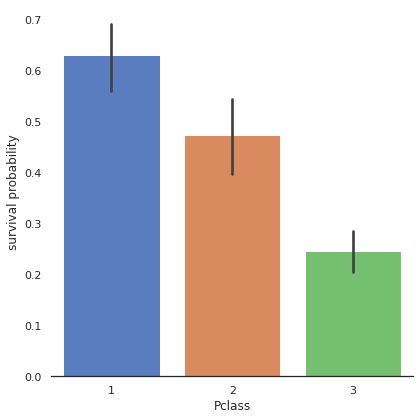

In [29]:
# Pclass vs Survived 탐색
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar',size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


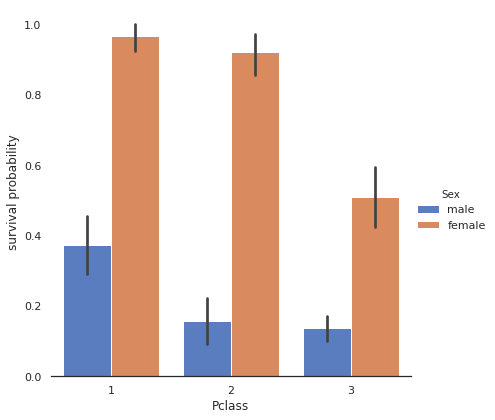

In [30]:
# 성별에 따른 Pclass vs Survived 탐색
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar',palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

3개 등급에서의 승객 생존율은 동일하지 않다. 1등급 승객들은 2,3등급 승객들보다 생존율이 높다.

이 경향은 남성과 여성 승객 모두에게서 나타난다.

Embarked

In [31]:
dataset['Embarked'].isnull().sum()

4

In [0]:
# 데이터셋의 Embarked NaN값을 가장 빈도수가 높은 'S'로 채우기
dataset['Embarked'] = dataset['Embarked'].fillna('S')

결측값이 4개이므로, 이를 'Embarked'의 최빈값인 S로 채웠다.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


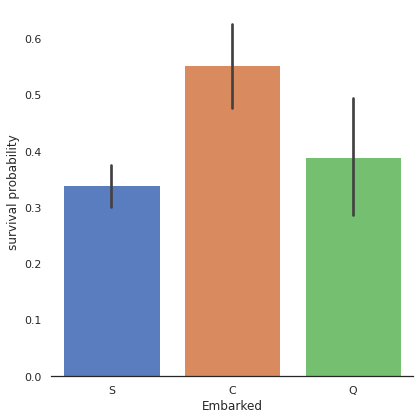

In [33]:
# Embarked vs Survived 탐색
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar',palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

Cherbourg(C)에서 온 승객들의 생존률이 더 높은 것으로 보인다.

나의 가설은 Cherbourg에서 온 사람들의 1등석 승객 비율이 Queenstown(Q),Southampton(S)보다 높다는 것이다.

Pclass 분포 vs Embarked 를 보자.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


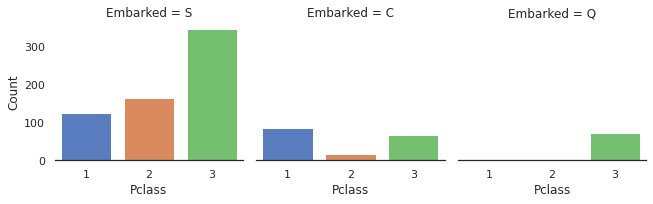

In [34]:
# Pclass vs Embarked 탐구
g = sns.factorplot('Pclass', col='Embarked', data = train, size=3, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

실제로, 3등석은 Southampton(S)과 Queenstown(Q) 승객에서 가장 빈번한 반면, Cherbourg 승객은 대부분 생존율이 가장 높은 1등석이다.

이 시점에서 1등석이 왜 생존율이 더 높은지 설명할 수는 없다. 나의 가설은 대피하는 동안 1등석 승객들의 영향으로 인해 우선 순위가 결정되었다는 것이다.

#4. 결측값 채우기

#####4.1 Age
Age 컬럼은 전체 데이터셋에서 347개의 결측값을 갖는다.

생존 확률이 높은 하위 집단(예 : 어린이)이 있기 때문에, age feature를 유지하고 결측값을 무시하는 것이 좋다.

이러한 문제를 해결하기 위해, Age와 가장 관련성 있는 feature(Sex, Parch, Pclass, SibSp)들을 살펴보았다.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

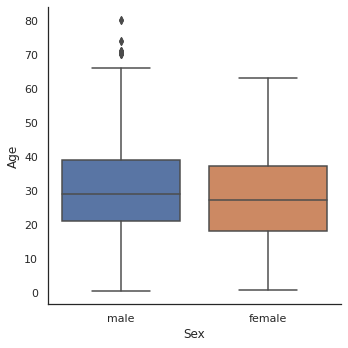

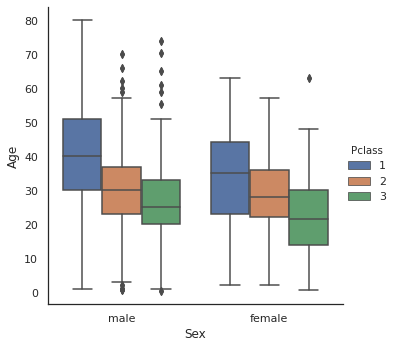

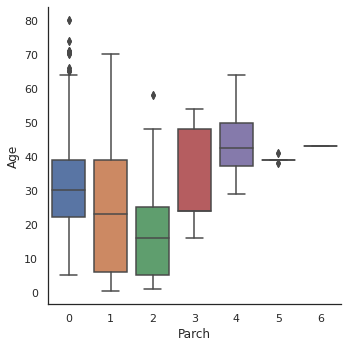

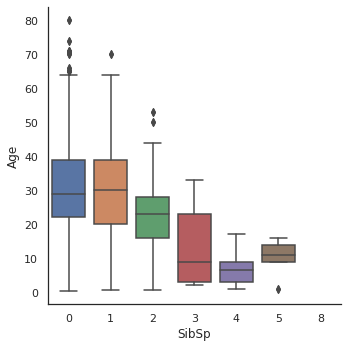

In [35]:
# Age vs Sex,Parch,Pclass, SibSp 탐색
g = sns.factorplot(y='Age',x='Sex',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='Sex',hue='Pclass',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='Parch',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='SibSp',data=dataset,kind='box')

연령 분포는 남성과 여성 하위 집단에서 동일하게 나타나므로, Sex는 Age를 예측하는 데 도움이 되지 않는다.

그러나, 1등석 승객들은 3등성 승객들보다 나이 많은 2등석 승객들보다 나이가 많다.

또한, 승객의 부모/자녀가 많을수록 나이가 많으며, 승객의 자매/배우자가 많을수록 나이가 적다. 

In [0]:
# Sex를 범주형 변수(0:남성, 1:여성)로 변환
dataset['Sex'] = dataset['Sex'].map({'male':0,'female':1})

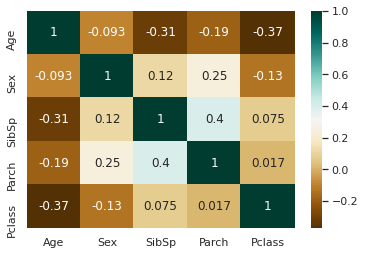

In [37]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),cmap='BrBG',annot=True)

correlation map은 Parch를 제외한 factorplots의 결과를 확인한다. 나이는 성별과 관련이 없지만 Pclass, Parch 및 SibSp와 음의 상관관계가 있다.

Parch의 기능에 따른 연령대에서, 나이는 부모/자녀의 수와 함께 증가하고 있다. 그러나 일반적으로는 음의 상관관계를 보인다.

따라서 나는 누락된 연령을 무시하기 위해 SibSp, Parch 및 Pclass를 사용하기로 결정했다.

전략은 Pclass, Parch 및 SibSp에 따른 유사한 행들의 중앙값으로 Age를 채우는 것이다.

In [38]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch, and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


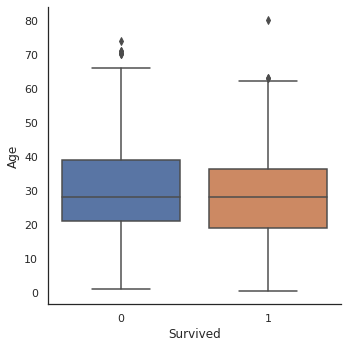

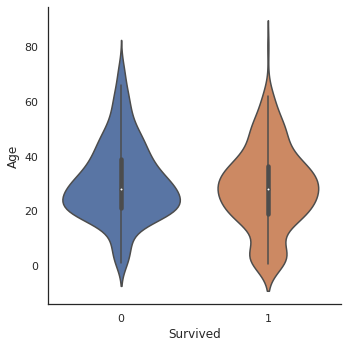

In [39]:
g = sns.factorplot(x='Survived', y= 'Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

생존과 사망 소집단 연령의 중앙값의 차이는 없었다. 

그러나 생존 승객의 바생존과 사망 소집단 연령의 중앙값의 차이는 없었다. 

그러나 생존 승객의 바이올린 플롯에서도 우리는 매우 어린 승객들의 생존율이 더 높은 것을 알 수 있다.

#5. Feature engineering

####5.1 Name/Title

In [40]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name feature는 승객의 타이틀에 대한 정보를 포함한다.

유명한 타이틀을 가진 승객이 우선 대피될 수 있으므로, 모델에 그들을 추가하는 것이 흥미롭다.

In [41]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

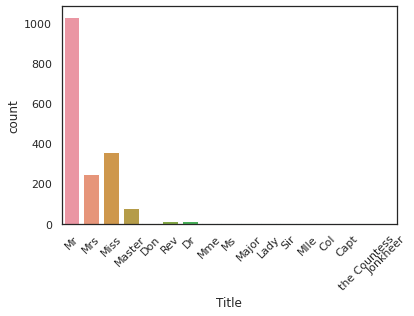

In [42]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

해당 데이터셋에는 17개의 타이틀이 있고, 대부분은 매우 드물기에 우리는 이를 4개 카테고리로 그룹화할 수 있다.

In [0]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

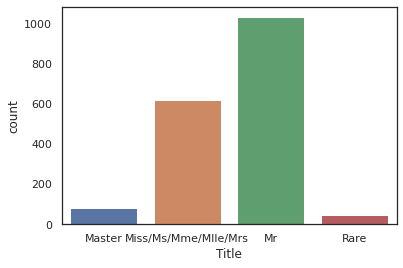

In [44]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


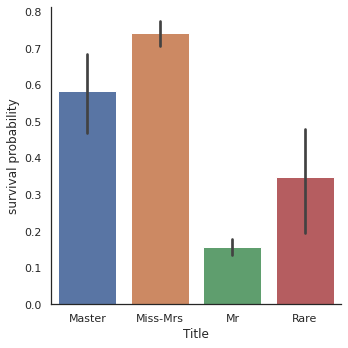

In [45]:
g = sns.factorplot(x='Title',y='Survived',data=dataset,kind='bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('survival probability')

"여성과 아이 먼저"

 희귀 타이틀을 가진 승객들이 생존할 가능성이 높다는 점에 주목하는 것이 흥미롭다.

In [0]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

####5.2 Family size

우리는 대피 동안 자매/형제/부모를 찾는 것에 따라 대가족의 생존 확률이 좀 더 높은 것을 기대할 수 있다. 따라서, 나는 'Fize'(family size) feature를 만들었고, 이것은 SibSp, Parch와 1(승객 본인을 포함)을 합한 것이다.

In [0]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


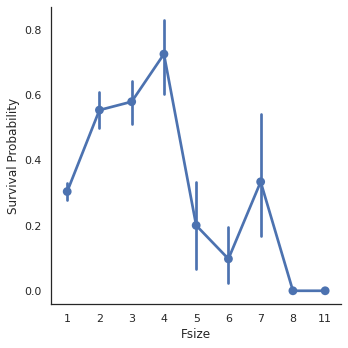

In [48]:
g = sns.factorplot(x='Fsize',y='Survived', data=dataset)
g = g.set_ylabels('Survival Probability')

가족의 규모는 중요한 역할을 하는 것으로 보이며, 대가족의 생존 확률이 가장 낮게 나타난다.

이에 더해, 나는 가족 규모의 4개 카테고리를 만들었다.

In [0]:
# create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


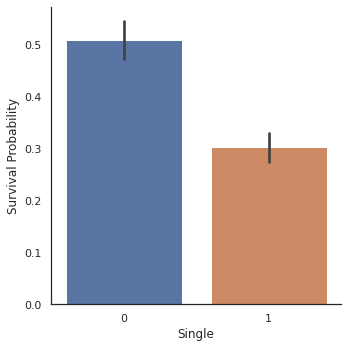

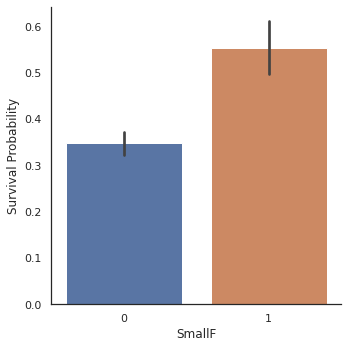

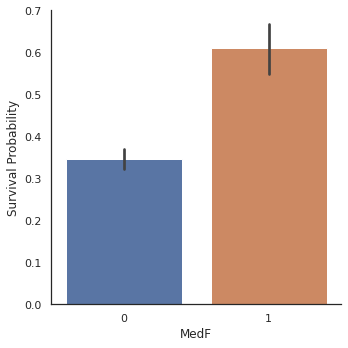

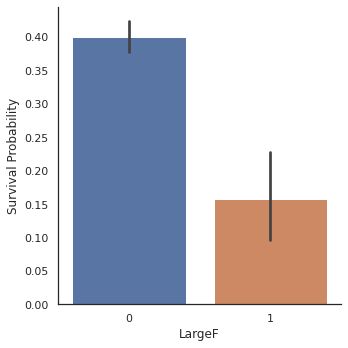

In [53]:
g = sns.factorplot(x='Single',y='Survived',data=dataset,kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='LargeF',y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

가족 규모 카테고리의 facorplots는 소, 중 규모의 가족들이 싱글와 대가족보다 생존 확률이 더 높다는 것을 보여준다.

In [0]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [55]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


이 단계에서, 우리는 22개의 feature를 갖는다.

#####5.3 Cabin

In [56]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [57]:
dataset['Cabin'].describe()

count         405
unique        147
top       B96 B98
freq            8
Name: Cabin, dtype: object

In [58]:
dataset['Cabin'].isnull().sum()

1367

Cabin feature 컬럼은 405개의 값과 1367개의 결측값을 포함한다.

아마도 객실 없는 승객들이 객실 넘버 대신 결측값으로 나타났을 것이다.

In [59]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [0]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'])

cabin의 첫 글자는 Desk를 가리키며, 이는 타이타닉호 승객들의 예상 위치를 알려주기 때문에 나는 이 정보는 갖고 있기로 했다. 

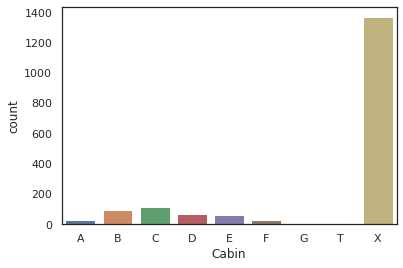

In [61]:
g = sns.countplot(dataset['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


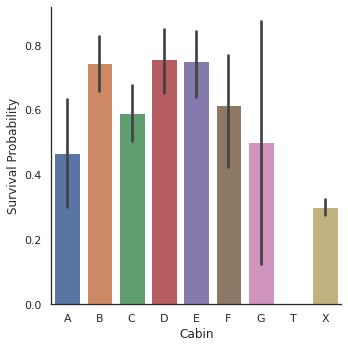

In [62]:
g = sns.factorplot(y='Survived',x='Cabin',data=dataset,kind='bar',order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

객실을 갖고 있던 승객의 수가 적기 때문에, 생존 확률은 중요한 표준 편차를 갖고 우리는 다른 데스크들에 있던 승객들의 생존율을 구별할 수 없다.

그러나 객실의 승객들이 (X)가 없는 승객들에 비해 일반적으로 생존 확률이 높은 것을 볼 수 있다.

특히 객실 B,C,D,E,F 에서 이를 확인할 수 있다.

In [0]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix='Cabin')

####5.4 Ticket

In [64]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

동일한 접두사를 공유하는 티켓들은 함께 배치된 객실을 예약했음을 의미한다. 따라서 이는 배 안의 선실들의 실제 위치로 이어질 수 있다.

접두사가 동일한 티켓들은 비슷한 객실 등급과 생존율을 가질 것이다.

따라서 Ticket feature 컬럼을 티켓 접두사로 대체하기로 했다. 이는 더 유익할 것이다.

In [65]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])  # Take Prefix
  else:
    Ticket.append('X')
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [0]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix='T')

In [0]:
# Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'],prefix='Pc')

In [0]:
# Drop useless variables
dataset.drop(labels = ['PassengerId'], axis=1, inplace =True)

In [69]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A4,T_A5,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_PC,T_PP,T_PPP,T_SC,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


#6.Modeling

In [70]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [71]:
# Separate train features and label

train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'],axis =1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


####6.1 Simple modeling

#####6.1.1 Cross validate models

인기있는 10개의 classifier를 비교하고, stratified k-fold 교차검증 절차를 통한 각각의 평균 정확성을 평가한다.

*   SVC
*   Decision Tree
*   AdaBoost
*   Random Forest
*   Extra Trees
*   Gradient Boosting
*   Multiple layer perceprton (neural network)
*   KNN
*   Logistic regression
*   Linear Discriminant Analysis



In [0]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [0]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))

classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))

classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))

classifiers.append(KNeighborsClassifier())

classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

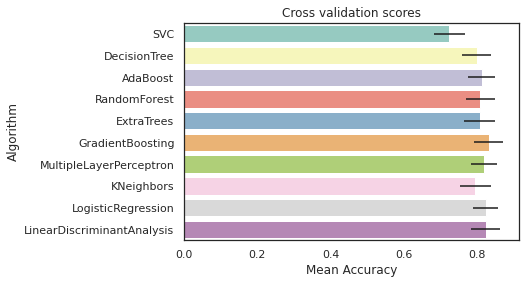

In [74]:
cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy',cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors':cv_std, 
                       'Algorithm':['SVC','DecisionTree','AdaBoost','RandomForest','ExtraTrees','GradientBoosting',
                                    'MultipleLayerPerceptron','KNeighbors','LogisticRegression','LinearDiscriminantAnalysis']})
g = sns.barplot('CrossValMeans','Algorithm',data = cv_res, palette='Set3',orient='h',**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting classifier들을 앙상블 모델링에 사용하기로 결정한다.

In [75]:
display(cv_res)

,CrossValMeans,CrossValerrors,Algorithm
0,0.724208,0.042904,SVC
1,0.798021,0.040492,DecisionTree
2,0.811645,0.036960,AdaBoost
3,0.808184,0.040095,RandomForest
4,0.807074,0.042014,ExtraTrees
5,0.830873,0.038852,GradientBoosting
6,0.818412,0.034697,MultipleLayerPerceptron
7,0.794574,0.042835,KNeighbors
8,0.822932,0.033765,LogisticRegression
9,0.822932,0.038751,LinearDiscriminantAnalysis


#####6.1.2 최적 모델을 위한 하이퍼파라미터 튜닝

AdaBoost, ExtraTrees, RandomForest, GradientBoosting, SVC classifier들을 위한 grid search 최적화를 수행했다.

4cpu를 갖고 있기에 'n_jobs' 파라미터를 4로 설정했다. 계산 시간은 명확하게 감소했다.

그러나 이 단계는 4cpu에서 15분이 소요되었기에 시간이 오래 걸릴 수 있으므로 조심해야 한다. 

In [76]:
## Meta modeling with AdaBoost, RF, ExtraTrees and GradientBoosting

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion': ['gini','entropy'],
                  'base_estimator__splitter': ['best','random'],'algorithm':['SAMME','SMME.R'],
                  'n_estimators':[1,2],
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_                

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1006 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    7.1s finished


In [77]:
gsadaDTC.best_score_

0.8093845760980592

In [78]:
#ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {'max_depth':[None],
                 'max_features':[1,3,10],
                 'min_samples_split':[2,3,10],
                 'min_samples_leaf':[1,3,10],
                 'bootstrap':[False],
                 'n_estimators':[100,300],
                 'criterion':['gini']}
gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv=kfold, scoring='accuracy',n_jobs=4, verbose=1)
gsExtC.fit(X_train, Y_train)
ExtC_best = gsExtC.best_estimator_

#Best score
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   39.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.0min finished


0.8331332992849847

In [79]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
               "criterion": ["gini"]}
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_

 # Best score
gsRFC.best_score_ 

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.2min finished


0.8343079673135853

In [80]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss':['deviance'],
                 'n_estimators':[100,200,300],
                 'learning_rate':[0.1,0.05,0.01],
                 'max_depth':[4,8],
                 'min_samples_leaf':[100,150],
                 'max_features':[0.3,0.1]}
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4,verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.4min finished


0.8388278855975486

In [81]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                  'gamma':[0.001,0.01,0.1,1],
                  'C': [1,10,50,100,200,300,1000]}
gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   41.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.2min finished


0.8331332992849848

#####6.1.3 학습 곡선 그리기

학습 곡선은 training set에 대한 과적합 효과와 training 크기가 정확성에 미치는 영향을 살펴보는 데에 좋은 방법이다.

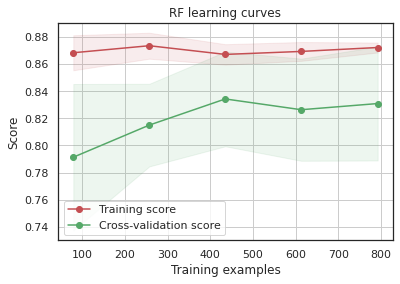

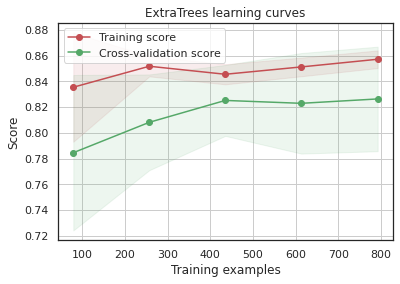

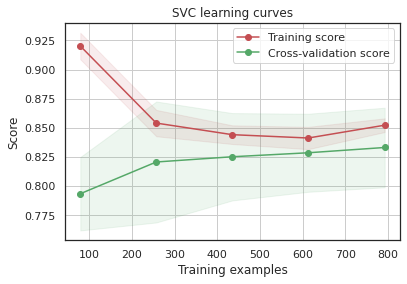

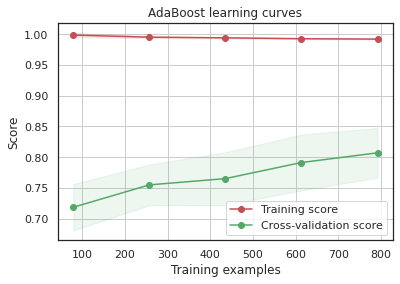

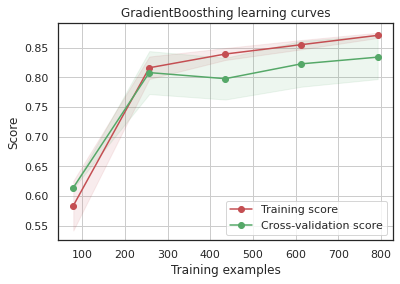

In [83]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
  """Generate a simple plot of the test and trainig learning curve"""
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training examples')
  plt.ylabel('Score')
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1,
                   color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1,
                   color='g')
  plt.plot(train_sizes, train_scores_mean,'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

  plt.legend(loc='best')
  return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv= kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv= kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv= kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosthing learning curves', X_train, Y_train, cv= kfold)

GradientBoosting과 Adaboost classifier 는 트레이닝셋에 과적합되는 경향이 있다. 교차 검증 곡선이 커짐에 따라 GradientBoosting과 Adaboost는 더 많은 트레이닝 예제에서 잘 수행될 수 있다.

SVC와 ExtraTrees classifier 는 트레이닝과 교차검증 커브가 서로 가까워짐에 따라 예측을 보다 일반화하는 것으로 보인다.

**6.1.4 트리 기반 classifier의 feature 중요성**

승객들의 생존율 예측에 가장 참고가 될 만한 feature를 보기 위해서, 4개의 트리 기반 calssifier들의 feature 중요성을 표시했다.

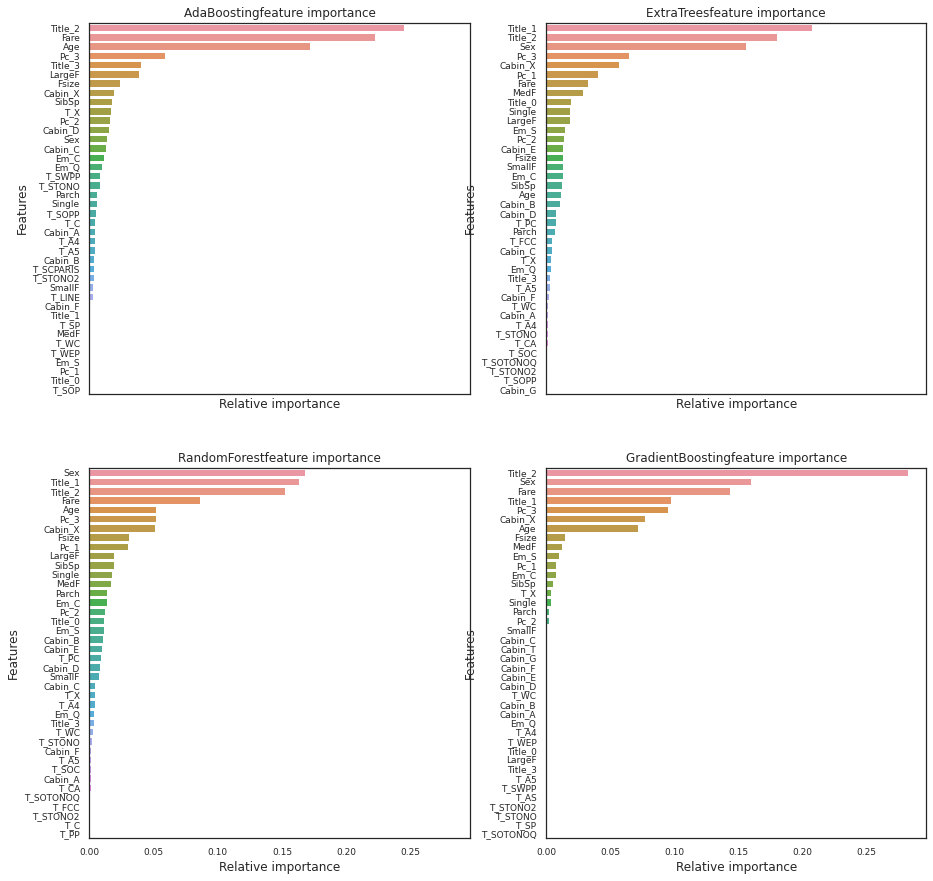

In [84]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex='all', figsize=(15,15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees',ExtC_best),('RandomForest',RFC_best),('GradientBoosting',GBC_best)]

nclassifier = 0
for row in range(nrows):
  for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40],
                    orient='h', ax=axes[row][col])
    g.set_xlabel('Relative importance', fontsize=12)
    g.set_ylabel('Features',fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + 'feature importance', fontsize=12)
    nclassifier += 1

4개의 트리 기반 classifier들(Adaboost, ExtraTrees, RandomForest, GradientBoosting)의 feature 중요성을 나타내었다.

4개의 classifier들은 연관 중요성에 따라 서로 다른 주요 feature들을 갖는다. 이는 그들의 예측이 동일한 feature들을 기반으로 하지 않음을 의미한다. 그럼에도 불구하고 분류에 공통적으로 중요한 기능(예 : 'Fare', 'Title_2', 'Age', 'Sex')이 있다.

Title_2는 Mrs/Mlle/Mme/Miss/Ms 카테고리가 성별과 강한 관계가 있음을 나타낸다.

우리는 이를 다음과 같이 말할 수 있다:
*   Pc_1, Pc_2, Pc_3, Fare는 승객들의 일반적인 사회적 위치를 나타낸다.
*   Sex와 Title_2(Mrs/Mlle/Mme/Miss/Ms), Title_3(Mr)는 성별을 나타낸다.
* Age와 Title_1(Master)는 승객들의 나이를 나타낸다.
* Fsize, LargeF, MedF, Single은 승객 가족의 규모를 나타낸다.

**해당 4개 classifier들의 feature 중요성에 따라서, 생존률 예측은 보트의 위치보다 승객들의 나이, 성별, 가족의 규모, 사회적 위치와 관련있어 보인다.**



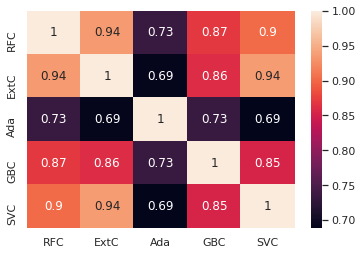

In [87]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test),name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test),name='GBC')

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True)

예측은 Adaboost가 다른 classifier들과 비교되었을 때를 제외하고 5개의 classifier들에서 꽤 유사하게 나타난다.

5개의 classifier들은 거의 동일한 예측을 내지만 여기에 약간의 차이가 있다. 이러한 5개의 classifier 예측 간의 차이는 ensembling vote를 고려하기에 충분하다. 

####6.2 Ensemble modeling

#####6.2.1 모델 결합

voting classifier를 선택하여 5가지 classifier에서 나온 예측을 결합했다.

각 vote의 확률을 고려하기 위해 'soft'인자를 voting 파라미터에 전달하는 것을 선호했다.


In [0]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac',ada_best), ('gbc',GBC_best)], voting = 'soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

####6.3 Prediction

#####6.3.1 결과 예측 및 제출

In [0]:
test_Survived = pd.Series(votingC.predict(test),name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('ensemble_python_voting.csv', index = False)